## Importing Libraries

In [1]:
import cv2

In [2]:
import numpy as np

In [3]:
import matplotlib.pyplot as plt

In [4]:
from xml.dom import minidom 
import os 

In [5]:
import base64
from PIL import Image
from io import BytesIO

In [6]:
import time

In [7]:
import datetime

## Encoding base64 image

In [8]:
def base64_encode_image(image_path):
    with open(image_path, "rb") as image_file:
        data = base64.b64encode(image_file.read())
    
    return str(data)

## Create XML 's root

In [9]:
root = minidom.Document() 
  
xml = root.createElement('root')  
root.appendChild(xml)


<DOM Element: root at 0x1ea629dc0d0>

## Write in xml

In [10]:
def write_in_xml(item,image_path,date):
    
    
    # Write item informations to xml
    
    ItemChild = root.createElement("item"+str(item)) 
    ItemChild.setAttribute('id',str(item))
    ItemChild.setAttribute('date-time',str(date))
    ItemChild.setAttribute('image',base64_encode_image(image_path))

    # 
    xml.appendChild(ItemChild) 
  
    xml_str = root.toprettyxml(indent ="\t")  
  
    save_path_file = "XML\datasets.xml"
  
    with open(save_path_file, "w+") as f:
        f.write(xml_str) 

## Template matching with feature matching (SIFT)

In [11]:
def sift_detector(new_image, image_template):
    # Function that compares input image to template
    # It then returns the number of SIFT matches between them
    try:
        image1 = cv2.cvtColor(new_image, cv2.COLOR_BGR2GRAY)
        image2 = image_template
    except:
        return 0
    
    # Create SIFT detector object
    #sift = cv2.SIFT()
    sift = cv2.SIFT_create()
    # Obtain the keypoints and descriptors using SIFT
    keypoints_1, descriptors_1 = sift.detectAndCompute(image1, None)
    keypoints_2, descriptors_2 = sift.detectAndCompute(image2, None)

    # Define parameters for our Flann Matcher
    FLANN_INDEX_KDTREE = 0
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 3)
    search_params = dict(checks = 150)

    # Create the Flann Matcher object
    flann = cv2.FlannBasedMatcher(index_params, search_params)

    # Obtain matches using K-Nearest Neighbor Method
    # the result 'matchs' is the number of similar matches found in both images
    matches = flann.knnMatch(descriptors_1, descriptors_2, k=2)

    # Store good matches using Lowe's ratio test
    good_matches = []
    for m,n in matches:
        if m.distance < 0.7 * n.distance:
            good_matches.append(m) 
    return len(good_matches)

## Template matching with feature matching (ORB)

In [12]:
def ORB_detector(new_image, image_template):
    # Function that compares input image to template
    # It then returns the number of ORB matches between them
    try:
        image1 = cv2.cvtColor(new_image, cv2.COLOR_BGR2GRAY)
    except:
        return 0

    # Create ORB detector with 1000 keypoints with a scaling pyramid factor of 1.2
    orb = cv2.ORB_create(1000, 1.2)

    # Detect keypoints of original image
    (kp1, des1) = orb.detectAndCompute(image1, None)

    # Detect keypoints of rotated image
    (kp2, des2) = orb.detectAndCompute(image_template, None)

    # Create matcher 
    # Note we're no longer using Flannbased matching
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    # Do matching
    matches = bf.match(des1,des2)

    # Sort the matches based on distance.  Least distance
    # is better
    matches = sorted(matches, key=lambda val: val.distance)
    return len(matches)

## Create a MobileNet SSD Object Detection model 

In [13]:
# Define detection model file's path
config_file = 'ssd_mobilenet_v3_large_coco_2020_01_14.pbtxt'
frozen_model = 'frozen_inference_graph.pb'

In [14]:
# Create a detection model
model = cv2.dnn_DetectionModel(frozen_model,config_file)

In [15]:
classLabels = []
file_name = "Labels.txt"
with open(file_name,'rt') as fpt:
    classLabels = fpt.read().rstrip('\n').split('\n')

In [16]:
print(len(classLabels))

80


In [17]:
# Setting input features

model.setInputSize(320,320)
model.setInputScale(1.0/127.5)
model.setInputMean((127.5,127.5,127.5))
model.setInputSwapRB(True)

<dnn_Model 000001EA605D8570>

## Example of object detection in image

In [19]:
plt.imshow(img)

NameError: name 'img' is not defined

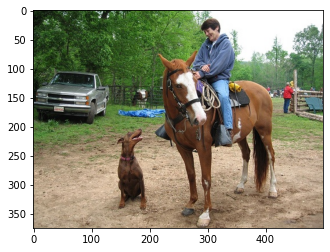

In [40]:
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

In [41]:
ClassIndex ,confidece ,bbox = model.detect(img,confThreshold = 0.5)

In [42]:
print(ClassIndex)

[[ 1]
 [19]
 [ 1]
 [ 1]
 [ 8]
 [19]
 [ 1]]


In [52]:
for ClassInd, conf, boxes in zip(ClassIndex.flatten(),confidece.flatten(),bbox):
    cv2.rectangle(img,boxes,(255,0,0),2)

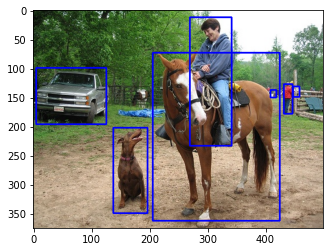

In [49]:
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

## Main Code

In [22]:
# Defines video capture
cap = cv2.VideoCapture(0)

image_template = cv2.imread("person.jpg")

if not cap.isOpened():
    raise IOError("Cannot open webcam")


# Time count for template capture
t0 = time.process_time()

# Define a threshold for template matching
threshold = 10

cropped = 0

# Load a id_count
with open("images\id_count.txt",'r+',encoding = 'utf-8') as f:
        id_count = int(f.read())

maxMatch = -1
id_ = -1

while True:
    ret,frame = cap.read()
    
    # Detect a ClassIndex ,confidece and bounding box. 
    ClassIndex ,confidece ,bbox = model.detect(frame,confThreshold = 0.55)
    
    
    if(len(ClassIndex)!= 0):
        for ClassInd, conf, boxes in zip(ClassIndex.flatten(),confidece.flatten(),bbox):
            if(ClassInd <= 80):
                cv2.rectangle(frame,boxes,(255,0,0),2)
                cropped = frame[boxes[1]:boxes[3]+boxes[1] , boxes[0]:boxes[2]+boxes[0]]
                
                # Template matching and searching  
                for i in range(0,id_count+1):
                    image_template = cv2.imread('images/id_'+str(i)+'.jpg')
                    matches = sift_detector(cropped, image_template)
                    print(matches)
                    if matches > threshold and matches >= maxMatch :    
                        id_ = i
                        t0 = time.process_time()
                        maxMatch = matches
                
                # İf 5 second passed and id_ = -1, item's template was saved
                if (time.process_time() - t0 > 5):
                    
                    cv2.imwrite("images/id_"+str(id_count+1)+".jpg",cropped)
                   
                    id_count +=1
                    
                    x = datetime.datetime.now()
                    
                    # item's information writting to xml.
                    write_in_xml(id_count,"images/id_"+str(id_count)+".jpg",x)
                    
                    # item's image saves to under the images folder.
                    with open("images/id_count.txt",'w+',encoding = 'utf-8') as f:
                        f.write(str(id_count))
                    
                    # Time count is restarted
                    t0 = time.process_time()
            
                
                
                if id_ != -1:     
                    cv2.putText(frame,'Object id:'+str(id_),(50,50), cv2.FONT_HERSHEY_COMPLEX, 2 ,(0,255,0), 2)
                    
                id_ = -1
                maxMatch = -1
    else:
        t0 = time.process_time()
    
    cv2.imshow('Object Detection',frame)
    
    
    if cv2.waitKey(2) & 0xFF == ord('q'):
        break
        
cap.release()
cv2.destroyAllWindows()


50
49
50
57
64
57
60
55
53
48
52
52
57
43
55
48
53
55
62
40
47
59
48
57
44
27
4
0
0
5
17
16
23
30
22
17
19
32
31
21
17
21
0
17
11
9
26
28
25
28
28
19
32
35
26
31
27
33
27
0
2
2
2
4
4
5
5
3
5
4
1
2
4
4
4
4
5
4
4
6
2
4
4
3
3
2
3
6
6
10
10
3
4
5
5
5
5
2
2
4
4
94
9
53
9
53
4
47
4
47
4
39
4
39
4
49
4
49
8
43
8
43
2
49
2
49
4
40
4
40
6
42
6
42
4
36
4
36
3
46
3
46
5
47
5
47
4
48
4
48
4
37
4
37
4
28
1
1
2
0
16
1
20
3
18
6
21
8
18
6
0
0
27
9
17
13
0
0
21
5
19
6
15
6
17
3
0
7
0
7
4
20
6
32
12
31
8
29
9
35
8
44
8
41
6
44
8
38
11
38
11
47
6
37
13
38
6
35
6
34
1
9
1
11
0
2
0
1
0
3
1
1
1
0
1
2
1
2
1
1
1
2
1
2
2
2
1
2
1
0
0
0
0
1
0
2
0
3
1
2
1
1
0
2
0
1
0
2
0
2
0
1
0
2
79
1
2
71
0
1
79
0
2
78
0
3
80
0
1
81
0
1
76
0
4
65
0
1
75
0
3
68
0
3
68
0
3
68
0
5
77
0
1
70
0
2
71
1
0
81
1
2
68
1
3
67
0
1
67
0
5
87
0
2
70
0
2
78
1
1
2
1
8
0
1
16
1
4
27
1
3
30
6
3
37
1
6
35
0
4
36
0
3
30
1
6
35
1
6
43
0
3
35
0
5
33
2
4
39
0
5
29
1
4
27
2
1
29
0
4
30
0
0
1
1
19
2
1
16
2
2
15
4
0
12
4
0
26
5
3
16
5
0
19
0
1
18
4
1
1